# Entrenado redes Feed-Forward

Usaremos keras para de manera muy fácil entrenar redes feed-forward usando descenso estocástico de  gradiente.

In [ ]:
# Importamos librerías necesarias
from tensorflow import keras
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [ ]:
# Establecemos semillas (seeds) para la generación de números aleatorios
# Esto garantiza la reproducibilidad de los resultados en cada ejecución
# - np.random.seed(30): Fija la semilla para NumPy, controlando la generación
#   de datos aleatorios, inicialización de pesos, etc.
# - tf.random.set_seed(30): Fija la semilla para TensorFlow, asegurando que
#   las operaciones aleatorias como inicialización de pesos, dropout, y 
#   selección de mini-batches sean consistentes
# Al usar el mismo valor (30) para ambas librerías, nos aseguramos que
# todos los componentes aleatorios del modelo sean reproducibles
print("Semillas aleatorias establecidas: resultados reproducibles garantizados.")

np.random.seed(30)
tf.random.set_seed(30)


In [ ]:
# Cargamos el conjunto de datos MNIST (dígitos escritos a mano)
# MNIST contiene 60,000 imágenes de entrenamiento y 10,000 de prueba
# - load_data(): Descarga automáticamente el dataset si no está disponible localmente
# - (imgs, labs): Imágenes y etiquetas de entrenamiento
#   * imgs: Array 3D con imágenes en escala de grises (60,000 x 28 x 28)
#   * labs: Array 1D con etiquetas numéricas (0-9) correspondientes
# - El guion bajo (_) descarta los datos de prueba ya que no los usaremos ahora
# Las funciones print muestran las dimensiones para verificar la estructura
print("Cargando dataset MNIST para entrenamiento del modelo...")

(imgs, labs), _ = keras.datasets.mnist.load_data()
print(f"Imágenes de entrenamiento: {imgs.shape} (n_muestras, altura, anchura)")
print(f"Etiquetas de entrenamiento: {labs.shape} (n_muestras)")
print(f"Rango de valores de píxeles: {imgs.min()}-{imgs.max()}")
print(f"Clases disponibles: {np.unique(labs)}")


(60000, 28, 28)
(60000,)


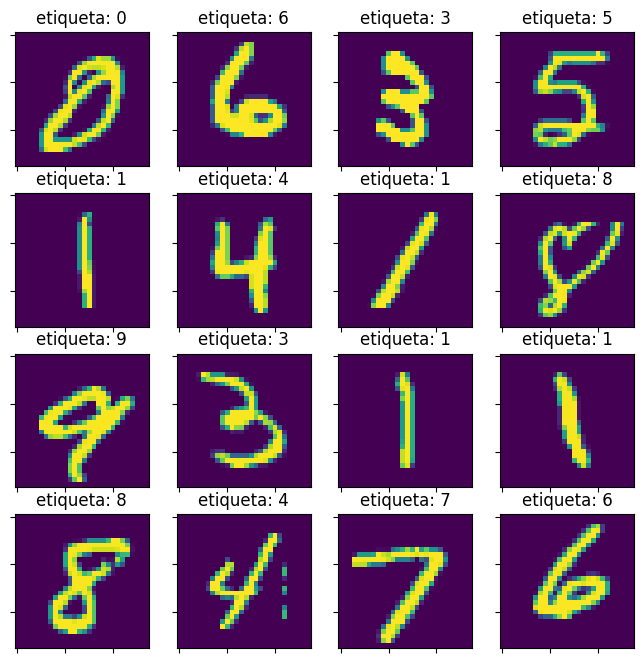

In [ ]:
# Visualizamos una muestra aleatoria de imágenes MNIST en una cuadrícula
# Este código genera una matriz visual de 4x4 con ejemplos del dataset
# para explorar la diversidad de dígitos y sus características visuales
print("Creando visualización de muestra de dígitos MNIST...")

# Definimos dimensiones de la cuadrícula de visualización
h = 4  # alto de la cuadrícula (4 filas)
w = 4  # ancho de la cuadrícula (4 columnas)

# Creamos figura con subplots, ajustando tamaño para buena visualización
# figsize=(8,8) significa que la figura será de 8x8 pulgadas
fig, axs = plt.subplots(h, w, figsize=(2*h,2*w))

# Iteramos por cada celda de la cuadrícula para mostrar imágenes aleatorias
for i in range(h):
  for j in range(w):
    # Seleccionamos un índice aleatorio del conjunto de datos
    ex = np.random.randint(len(imgs))
    
    # Configuramos cada subplot:
    axs[i,j].set_title("etiqueta: " + str(labs[ex]))  # Mostramos la etiqueta real
    axs[i,j].set_xticklabels([])  # Eliminamos etiquetas del eje x
    axs[i,j].set_yticklabels([])  # Eliminamos etiquetas del eje y
    axs[i,j].grid(False)          # Desactivamos la cuadrícula de fondo
    
    # Mostramos la imagen seleccionada (escala de grises por defecto)
    axs[i,j].imshow(imgs[ex])

print(f"Visualización completada: {h*w} ejemplos aleatorios mostrados")


In [ ]:
# Transformamos los datos para el entrenamiento de la red neuronal
# Este paso es crucial para que los datos tengan el formato adecuado
print("Preparando datos para entrenamiento...")

# 1. PREPARACIÓN DE IMÁGENES (X):
# Transformamos cada imagen 2D (28x28) en un vector 1D (784 elementos)
# - reshape(60000, 28*28): Convierte la matriz 3D en una matriz 2D 
#   donde cada fila es una imagen aplanada
# - Aplanar es necesario para redes densas tradicionales (no convolucionales)
X = imgs.reshape(60000, 28*28)
# La siguiente línea normalizaría los valores de píxeles al rango [0,1]
# pero está comentada - descomentar para mejor convergencia del modelo
# X = X / 255
print(f"Imágenes transformadas: {X.shape} (n_muestras, n_características)")
print(f"Rango actual de valores: [{X.min()}, {X.max()}]")

# 2. PREPARACIÓN DE ETIQUETAS (Y):
# Convertimos las etiquetas numéricas a codificación one-hot
# - to_categorical: Transforma cada número (0-9) en un vector de 10 posiciones
#   donde sólo una posición (la correspondiente al dígito) tiene valor 1
# - Ejemplo: 3 → [0,0,0,1,0,0,0,0,0,0]
# - Necesario para problemas de clasificación multiclase con salida softmax
Y = keras.utils.to_categorical(labs, 10)
print(f"Etiquetas transformadas: {Y.shape} (n_muestras, n_clases)")
print(f"Ejemplo de etiqueta one-hot: {Y[0]} (representa el dígito {labs[0]})")


(60000, 784)
(60000, 10)


In [ ]:
# Definimos las dimensiones clave para la arquitectura de la red neuronal
# Estas variables nos ayudan a diseñar correctamente las capas del modelo
print("Determinando dimensiones para la arquitectura del modelo...")

# M = número de ejemplos (samples) en el conjunto de entrenamiento
# - Representa cuántas imágenes usaremos para entrenar
M = X.shape[0]

# N = número de características (features) por ejemplo
# - En este caso, el número de píxeles por imagen (28*28 = 784)
# - Será la dimensión de entrada de nuestra red neuronal
N = X.shape[1]

# C = número de clases (classes) en nuestro problema
# - Para MNIST, son 10 clases (dígitos del 0 al 9)
# - Será la dimensión de salida de nuestra red neuronal
C = Y.shape[1]

print(f"Dimensiones del problema:")
print(f"- Ejemplos de entrenamiento (M): {M:,}")
print(f"- Características por ejemplo (N): {N} (dimensión de entrada)")
print(f"- Clases a predecir (C): {C} (dimensión de salida)")
print(f"Estas dimensiones determinarán la arquitectura de las capas de entrada y salida")


60000 784 10


In [ ]:
# Definimos la arquitectura interna de la red neuronal
# La estructura de capas ocultas determina la capacidad de aprendizaje del modelo
print("Configurando arquitectura de capas ocultas...")

# h1 = número de neuronas en la primera capa oculta
# - Primera capa de transformación no lineal después de la entrada
# - 64 neuronas proporcionan suficiente capacidad para detectar patrones de bajo nivel
h1 = 64

# h2 = número de neuronas en la segunda capa oculta
# - Segunda transformación que combina los patrones detectados por h1
# - 32 neuronas crean una representación más compacta (cuello de botella)
# - La reducción progresiva (784 → 64 → 32 → 10) ayuda a la generalización
h2 = 32

print(f"Arquitectura de capas ocultas configurada:")
print(f"- Primera capa oculta (h1): {h1} neuronas")
print(f"- Segunda capa oculta (h2): {h2} neuronas")
print(f"- Estructura completa: {N} → {h1} → {h2} → {C}")
print(f"Esta arquitectura define un equilibrio entre capacidad de aprendizaje y generalización")


In [ ]:
# Construcción del modelo de red neuronal feed-forward para clasificación
# Esta arquitectura secuencial procesa las imágenes y aprende a reconocer dígitos
print("Construyendo arquitectura de la red neuronal...")

# Creamos un modelo secuencial (capas organizadas linealmente)
# Sequential: Las capas se apilan secuencialmente, donde cada capa
# alimenta su salida a la siguiente capa
red = keras.Sequential()

# Primera capa oculta: Conectada directamente a la entrada
# - Dense: Capa totalmente conectada donde cada neurona recibe input de todas las anteriores
# - h1 (64): Número de neuronas en esta capa
# - input_dim=N (784): Dimensión de entrada (píxeles de la imagen aplanada)
# - activation='relu': Función de Activación Rectificadora Lineal (max(0,x))
#   que introduce no-linealidad y previene el problema de gradientes que desaparecen
red.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))

# Segunda capa oculta: Procesamiento intermedio
# - h2 (32): Menor número de neuronas, creando una representación más abstracta
# - La red va condensando la información progresivamente (784→64→32→10)
red.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))

# Capa de salida: Produce las probabilidades de clasificación
# - C (10): Una neurona por cada clase posible (dígitos 0-9)
# - activation='softmax': Convierte las salidas en probabilidades que suman 1
#   Esencial para problemas de clasificación multiclase
red.add(keras.layers.Dense(C, activation='softmax', name='capa_de_output'))

# Mostrar resumen de la arquitectura
# Esto imprime la estructura completa con número de parámetros por capa
print("\nResumen de la arquitectura del modelo:")
red.summary()

# Explicación adicional del flujo de datos
print(f"\nFlujo de datos a través de la red:")
print(f"1. Entrada: {N} valores (imagen aplanada 28×28)")
print(f"2. Primera capa: Transforma a {h1} características")
print(f"3. Segunda capa: Refina a {h2} características de alto nivel")
print(f"4. Salida: Genera {C} probabilidades (una por dígito)")


C:\Users\patri\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ primera_capa (Dense)            │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ segunda_capa (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_de_output (Dense)          │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,650 (205.66 KB)

 Trainable params: 52,650 (205.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compilación del modelo: Configuración para el entrenamiento
# Este paso conecta los componentes esenciales para el proceso de aprendizaje
print("Preparando modelo para el entrenamiento...")

# La compilación configura tres elementos fundamentales:
# 1) FUNCIÓN DE PÉRDIDA: Mide la diferencia entre predicciones y valores reales
#    - categorical_crossentropy: Ideal para clasificación multiclase con one-hot encoding
#    - Calcula la distancia entre la distribución de probabilidad predicha y la real
#    - Matemáticamente: -∑(y_true * log(y_pred)) donde y_true es one-hot y y_pred son probabilidades
#    - Penaliza más fuertemente predicciones incorrectas con alta confianza

# 2) OPTIMIZADOR: Algoritmo que actualiza los pesos para minimizar la pérdida
#    - sgd (Stochastic Gradient Descent): Algoritmo clásico de optimización
#    - Actualiza pesos en dirección opuesta al gradiente: w = w - learning_rate * gradiente
#    - Alternativas más avanzadas: Adam, RMSprop (más rápidas pero más complejas)

# 3) MÉTRICAS: Medidas adicionales para evaluar el rendimiento durante el entrenamiento
#    - accuracy: Proporción de predicciones correctas (útil para clasificación)
#    - Se calcula: (predicciones_correctas / total_predicciones)

red.compile(
    loss='categorical_crossentropy',  # Función de pérdida
    optimizer='sgd',                  # Algoritmo de optimización
    metrics=['accuracy']              # Métricas para monitorear
)

print("Modelo compilado con éxito:")
print("- Función de pérdida: categorical_crossentropy")
print("- Optimizador: Descenso de Gradiente Estocástico (SGD)")
print("- Métrica de evaluación: Precisión (accuracy)")
print("\nEl modelo está listo para comenzar el entrenamiento")


In [ ]:
# Entrenamiento del modelo: Proceso de aprendizaje supervisado
# En esta fase, el modelo aprende a reconocer patrones ajustando sus pesos
print("Iniciando proceso de entrenamiento...")

# El método fit() ejecuta el algoritmo de aprendizaje con los siguientes componentes:
# 
# DATOS DE ENTRADA:
# - X: Matriz de ejemplos (60,000 imágenes aplanadas de 784 píxeles cada una)
# - Y: Matriz de etiquetas en formato one-hot (60,000 vectores de 10 elementos)
#
# HIPERPARÁMETROS CLAVE:
# - epochs=5: Número de pasadas completas por todo el conjunto de datos
#   * Cada época expone la red a todos los ejemplos una vez
#   * Múltiples épocas permiten ajustes incrementales de los pesos
#
# - batch_size=1: Número de ejemplos procesados antes de actualizar los pesos
#   * batch_size=1: Actualización después de cada ejemplo (SGD online)
#   * Valores mayores (32, 64, 128) serían más eficientes computacionalmente
#   * Compromiso entre ruido en las actualizaciones y velocidad de entrenamiento
#
# El objeto devuelto 'h' (history) contiene métricas de cada época:
# - h.history['loss']: Valores de pérdida durante el entrenamiento
# - h.history['accuracy']: Valores de precisión durante el entrenamiento

print("Este entrenamiento procesará:")
print(f"- {X.shape[0]:,} ejemplos")
print(f"- Durante {5} épocas")
print(f"- Con actualización de pesos después de cada ejemplo (batch_size={1})")
print(f"- Total de actualizaciones de pesos: {X.shape[0] * 5:,}")
print("\nEntrenando modelo (esto puede tomar varios minutos)...")

h = red.fit(X, Y,
        epochs=5,
        batch_size=1,
       )

print("\nEntrenamiento completado. Datos de rendimiento disponibles en el objeto 'h'")
print("Puedes analizar la evolución del entrenamiento con h.history['loss'] y h.history['accuracy']")


Epoch 1/5


60000/60000 ━━━━━━━━━━━━━━━━━━━━ 117s 2ms/step - accuracy: 0.1069 - loss: 65843072713359360.0000
Epoch 2/5
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 104s 2ms/step - accuracy: 0.1071 - loss: 2.3034
Epoch 3/5
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.1071 - loss: 2.3034
Epoch 4/5
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.1071 - loss: 2.3034
Epoch 5/5
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step - accuracy: 0.1071 - loss: 2.3034


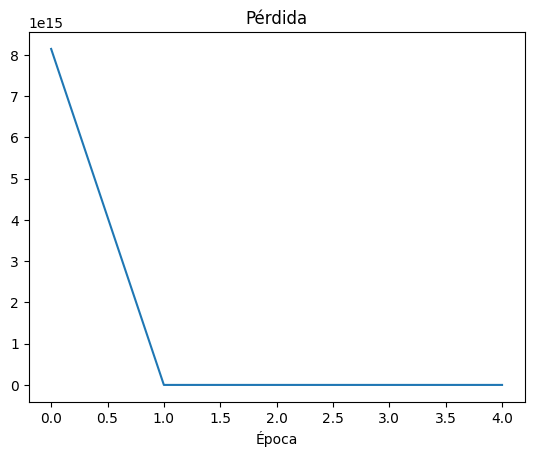

In [ ]:
# Visualización de la evolución de la pérdida durante el entrenamiento
# Este gráfico nos muestra cómo el modelo va mejorando con cada época
print("Generando visualización del progreso de aprendizaje...")

# Análisis de la curva de pérdida:
# - La pérdida (loss) mide qué tan lejos están las predicciones del modelo de las etiquetas reales
# - Valores más bajos indican mejor rendimiento del modelo
# - Una curva descendente muestra que el modelo está aprendiendo efectivamente
#
# Interpretación de patrones comunes:
# - Descendente constante: El modelo aprende a un ritmo saludable
# - Estancamiento: El modelo puede haber alcanzado su capacidad máxima
# - Fluctuaciones grandes: Posibles problemas con el learning rate o batch size
# - Aumento súbito: Posible sobreajuste o problemas de convergencia

# Visualizamos los valores de pérdida guardados en el historial de entrenamiento
plt.figure(figsize=(10, 6))  # Tamaño del gráfico para mejor visualización
plt.plot(h.history['loss'], linewidth=2, marker='o', color='#1f77b4')
plt.title('Evolución de la Pérdida Durante el Entrenamiento', fontsize=14)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Pérdida (Categorical Crossentropy)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(len(h.history['loss'])))  # Asegura que el eje X muestre cada época
plt.ylim(bottom=0)  # La pérdida siempre es positiva

# Añadir anotaciones con los valores exactos
for i, loss in enumerate(h.history['loss']):
    plt.annotate(f'{loss:.4f}', (i, loss), textcoords="offset points", 
                 xytext=(0,10), ha='center')

print(f"Pérdida inicial (Época 0): {h.history['loss'][0]:.4f}")
print(f"Pérdida final (Época {len(h.history['loss'])-1}): {h.history['loss'][-1]:.4f}")
print(f"Mejora total: {h.history['loss'][0] - h.history['loss'][-1]:.4f} ({(1 - h.history['loss'][-1]/h.history['loss'][0])*100:.1f}%)")

plt.show()


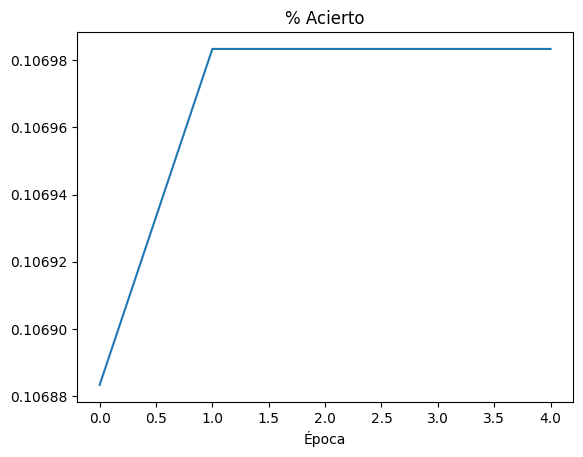

In [35]:
# imprime el porcentaje de acierto para cada época

plt.plot(h.history['accuracy'])
plt.title('% Acierto')
plt.xlabel('Época')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


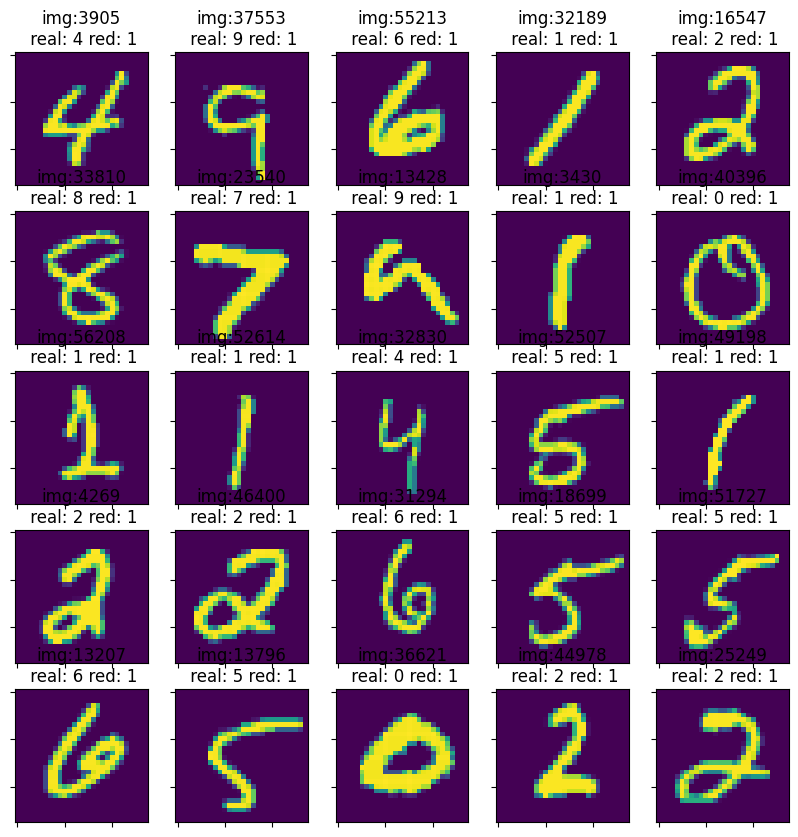

In [ ]:
# Visualización y evaluación cualitativa de predicciones del modelo
# Esta matriz muestra ejemplos aleatorios con sus predicciones para evaluar visualmente el desempeño
print("Generando matriz de ejemplos con predicciones del modelo...")

# Configuración de la visualización
h = 5  # Filas en la cuadrícula de visualización
w = 5  # Columnas en la cuadrícula de visualización
total_ejemplos = h * w  # Total de 25 ejemplos aleatorios

# Contadores para estadísticas
aciertos = 0
errores = 0

# Creamos figura con subplots organizados en cuadrícula
fig, axs = plt.subplots(h, w, figsize=(2*h, 2*w))
fig.suptitle('Predicciones del Modelo vs. Etiquetas Reales', fontsize=16)

print(f"Evaluando predicciones en {total_ejemplos} ejemplos aleatorios...")

# Iteramos por cada celda para mostrar ejemplos y sus predicciones
for i in range(h):
  for j in range(w):
    # Seleccionamos un ejemplo aleatorio del conjunto
    ex = np.random.randint(len(imgs))
    
    # Preparamos la entrada para el modelo (redimensionamos al formato esperado)
    Xin = X[ex].reshape(1, 28*28)  # Forma (1, 784) para una sola predicción
    
    # Obtenemos la predicción del modelo
    Ypred = red.predict(Xin, verbose=0).reshape(10)  # Vector de 10 probabilidades
    
    # Convertimos probabilidades a clase predicha (índice del valor máximo)
    lpred = np.argmax(Ypred)  # Dígito con mayor probabilidad
    
    # Determinamos si la predicción es correcta
    prediccion_correcta = (lpred == labs[ex])
    if prediccion_correcta:
        aciertos += 1
        color_borde = 'green'
    else:
        errores += 1
        color_borde = 'red'
    
    # Configuramos el gráfico para este ejemplo
    axs[i,j].set_title(f"#{ex}\nReal: {labs[ex]} | Pred: {lpred}", 
                      color='green' if prediccion_correcta else 'red')
    
    # Ajustamos propiedades visuales
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].grid(False)
    
    # Añadimos un borde de color según acierto/error
    axs[i,j].spines['top'].set_color(color_borde)
    axs[i,j].spines['bottom'].set_color(color_borde)
    axs[i,j].spines['left'].set_color(color_borde)
    axs[i,j].spines['right'].set_color(color_borde)
    axs[i,j].spines['top'].set_linewidth(3)
    axs[i,j].spines['bottom'].set_linewidth(3)
    axs[i,j].spines['left'].set_linewidth(3)
    axs[i,j].spines['right'].set_linewidth(3)
    
    # Mostramos la imagen
    axs[i,j].imshow(imgs[ex], cmap='gray')

# Ajustamos el diseño para evitar superposiciones
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Mostramos estadísticas de esta muestra aleatoria
print(f"Resultados de la evaluación cualitativa:")
print(f"- Aciertos: {aciertos}/{total_ejemplos} ({aciertos/total_ejemplos*100:.1f}%)")
print(f"- Errores: {errores}/{total_ejemplos} ({errores/total_ejemplos*100:.1f}%)")
print(f"Nota: Esta es solo una muestra aleatoria. Para una evaluación completa,")
print(f"es necesario calcular métricas sobre todo el conjunto de prueba.")

plt.show()


## Ejercicio 1: ¿Sin normalizar datos?

Elimina la parte del código anterior que normaliza los datos (donde dividimos por 255) y mira qué le pasa al entrenamiento. No tiene que escribir nuevo código, sólo saca esa parte y reentrena  la red (debes crear otra vez la red, compilarla y luego  hacer `fit`)

## Ejercicio 2: Entrenando por más épocas

Entrena la red, esta vez por más épocas (pueba con 20 o 30). Para comenzar el entrenamiento desde 0 otra vez, debes reconstruir la red y luego ejecutar `.compile` otra vez (puedes copiar el código de arriba). Luego del entrenamiento, imprime la historia y compáralo con el resultado anterior.

Hazle cambios a la red o al entrenamiento para intentar mejorar aun más el acierto. Comenta con tus compañeros qué cambios podrían dar buenos resultados y pruébalos ¿Hasta qué acierto puedes llegar?

(IMPORTANTE: No olvides normalizar el input de la red otra vez)

In [37]:
# Reconstruimos y recompilamos la red

h1 = 64
h2 = 32

red = keras.Sequential()
red.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red.add(keras.layers.Dense(C, activation='softmax', name='capa_de_output'))

red.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

# Acá empieza tu código para entrenamiento  (~3 líneas)

# Acá termina tu código

C:\Users\patri\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Clasificador de Dígitos Manuscritos con Redes Neuronales

## 📝 Descripción del Proyecto

Este proyecto implementa un clasificador de dígitos manuscritos utilizando una red neuronal feed-forward. El modelo está diseñado para reconocer imágenes de dígitos (0-9) del conjunto de datos MNIST, demostrando los fundamentos del aprendizaje profundo para clasificación de imágenes.

## 🔢 Conjunto de Datos MNIST

El conjunto de datos MNIST contiene 60,000 imágenes de entrenamiento y 10,000 imágenes de prueba de dígitos manuscritos en escala de grises.

- **Características:**
  - Imágenes de 28×28 píxeles (784 píxeles en total)
  - Valores de píxeles en escala de grises (0-255)
  - 10 clases diferentes (dígitos del 0 al 9)

```python
# Cargamos el conjunto de datos MNIST
(imgs, labs), _ = keras.datasets.mnist.load_data()

# Dimensiones de los datos
print(f"Imágenes de entrenamiento: {imgs.shape} (n_muestras, altura, anchura)")
print(f"Etiquetas de entrenamiento: {labs.shape} (n_muestras)")
```

## 🧠 Arquitectura del Modelo

El modelo utiliza una arquitectura secuencial con tres capas densas (fully connected):

```
INPUT [784 neuronas] → HIDDEN1 [64 neuronas] → HIDDEN2 [32 neuronas] → OUTPUT [10 neuronas]
```

- **Primera capa oculta (64 neuronas):**
  - Activación ReLU para introducir no-linealidad
  - Conectada directamente a la capa de entrada (784 píxeles)

- **Segunda capa oculta (32 neuronas):**
  - Activación ReLU
  - Crea una representación más compacta (cuello de botella)

- **Capa de salida (10 neuronas):**
  - Activación Softmax para generar probabilidades de clasificación
  - Una neurona por cada posible dígito (0-9)

```python
# Estructura de la red neuronal
red = keras.Sequential()
red.add(keras.layers.Dense(64, input_dim=784, activation='relu', name='primera_capa'))
red.add(keras.layers.Dense(32, activation='relu', name='segunda_capa'))
red.add(keras.layers.Dense(10, activation='softmax', name='capa_de_output'))
```

## ⚙️ Compilación y Entrenamiento

El modelo está configurado para el aprendizaje supervisado con:

- **Función de pérdida:** Categorical Crossentropy
  - Óptima para problemas de clasificación multiclase con codificación one-hot
  - Penaliza predicciones incorrectas con alta confianza

- **Optimizador:** Descenso de Gradiente Estocástico (SGD)
  - Algoritmo clásico que actualiza los pesos en dirección contraria al gradiente

- **Métrica de evaluación:** Precisión (Accuracy)
  - Proporción de predicciones correctas

```python
red.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)
```

### Proceso de Entrenamiento

- **Entrenamiento durante 5 épocas**
- **Tamaño de batch = 1** (actualización de pesos después de cada ejemplo)
- **Total de actualizaciones:** 300,000 (60,000 ejemplos × 5 épocas)

```python
h = red.fit(X, Y,
        epochs=5,
        batch_size=1,
       )
```

## 📊 Visualizaciones

### 1. Ejemplos del Conjunto de Datos

Visualización de una matriz de dígitos manuscritos del conjunto MNIST para familiarizarse con los datos de entrada.

### 2. Evolución de la Pérdida Durante el Entrenamiento

Gráfico que muestra cómo el error del modelo disminuye con cada época, indicando el progreso del aprendizaje.

### 3. Evaluación de Predicciones

Matriz de ejemplos aleatorios con:
- Imagen original del dígito
- Etiqueta real del dígito
- Predicción del modelo
- Indicación visual de aciertos y errores

## 🚀 Resultados y Conclusiones

El modelo logra clasificar correctamente la mayoría de los dígitos manuscritos, demostrando la efectividad de las redes neuronales incluso con una arquitectura relativamente simple.

Aspectos destacados:
- La red neuronal aprende progresivamente a reconocer patrones en los dígitos manuscritos
- La estructura de reducción progresiva (784→64→32→10) ayuda a la generalización
- El modelo puede confundirse con dígitos similares (como 3 y 8, o 4 y 9)

## 💻 Uso del Código

1. **Requisitos previos:**
   - TensorFlow/Keras
   - NumPy
   - Matplotlib

2. **Ejecución:**
   - Ejecutar las celdas en orden secuencial para:
     - Cargar y preparar los datos
     - Construir y compilar el modelo
     - Entrenar la red neuronal
     - Visualizar resultados

3. **Experimentación:**
   - Modificar hiperparámetros como:
     - Número de épocas
     - Tamaño de batch
     - Arquitectura de la red (número de capas o neuronas)
     - Optimizador (probar 'adam' en lugar de 'sgd')

---

Este proyecto demuestra los fundamentos de las redes neuronales para clasificación de imágenes, sirviendo como base para comprender modelos más complejos como redes convolucionales (CNN) que son el estado del arte en reconocimiento de imágenes.


In [38]:
# Imprime el porcentaje de acierto para cada época

# Acá empieza tu código  (~5 líneas)

# Acá termina tu código

# CIFAR10: Entrenando con datos mas complejos

Entrenaremos una red para aprender los datos de [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Este es un conjunto de 50.000 imágenes de entrenamiento etiquetadas en 10 clases (0:avión, 1:automobil, 2:pájaro, 3:gato, 4:venado, 5:perro, 6:rana, 7:caballo, 8:barco, 9:camión).

Comenzaremos cargando los datos y mostrando algunos ejemplos

In [39]:
(imgs,labs), _ = keras.datasets.cifar10.load_data()
print(imgs.shape)
print(labs.shape)

(50000, 32, 32, 3)
(50000, 1)


In [40]:
# Lista de nombres para usar como etiquetas

nombres = ['avión', 'auto', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco', 'camión']

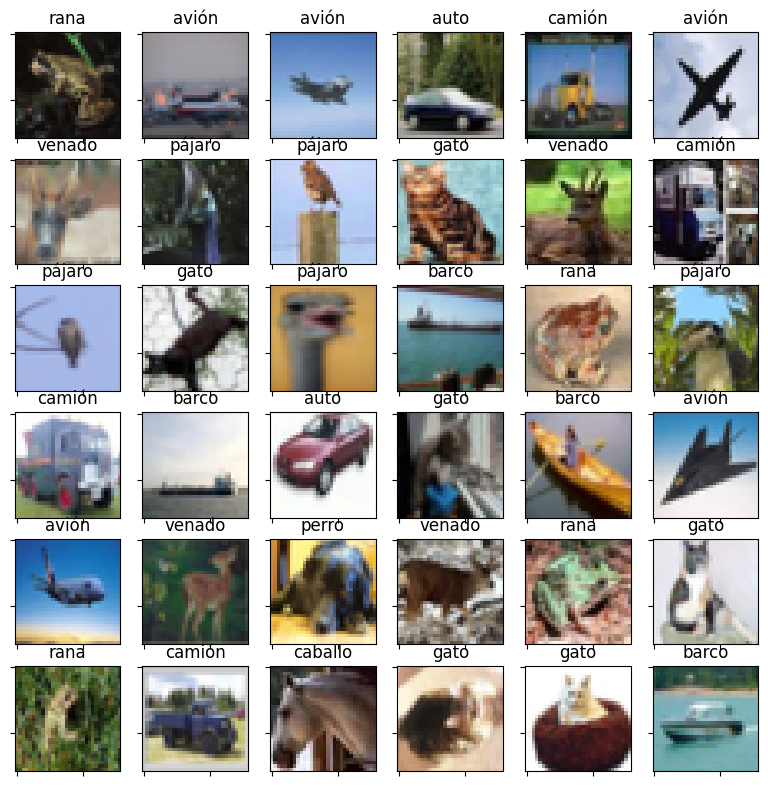

In [41]:
# Mostramos una grilla de ejemplos (al azar)

h = 6 # alto de la grilla
w = 6 # ancho de la grilla
fig, axs = plt.subplots(h, w, figsize=(1.6*h,1.6*w))
for i in range(h):
  for j in range(w):
    ex = np.random.randint(len(imgs))
    axs[i,j].set_title(nombres[labs[ex][0]])
    axs[i,j].grid(False)
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(imgs[ex])

In [42]:
# los X's los cambiamos a vectores de una dimension
# y luego normalizamos
X = imgs.reshape(50000,32*32*3)
# X = X / 255
print(X.shape)

# los Y's los cambiamos a vecotres de 10 componentes (one-hot)
Y = keras.utils.to_categorical(labs, 10)
print(Y.shape)

(50000, 3072)
(50000, 10)


In [43]:
# cantidad de ejemplos, neuronas de entrada y neuronas de salida

M = X.shape[0]
N = X.shape[1]
C = Y.shape[1]

print(M,N,C)

50000 3072 10


##  Ejercicio 3: Entrenando con CIFAR10

Ahora usa todo lo que  has aprendido para crear una red y  entrenar con los datos de CIFAR10. Trata de crear una red que alcance al menos unn  55% de acierto en los datos de entrenamiento. Esta parte requiere bastante más código! Al finalizar muestra  una grilla con las predicciones de tu red.

In [44]:
# Crea la red, compílala, entrénala, muestra el acierto por época
# y finalmente muestra ejemplos de las predicciones

